## Color vs Mass for different subsamples ##



In [1]:
import sys
sys.path.append("/Users/rfinn/github/Virgo/programs")

In [2]:
########################################
###### IMPORT MODULES  ########
########################################

from astropy.io import fits
from virgoCommon import *
import pylab as plt
import numpy as np
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
from astroquery.skyview import SkyView

from astropy.coordinates import EarthLocation
from astropy.time import Time

from astropy.coordinates import AltAz

from astroplan import Observer
from astroplan.plots import plot_airmass

from matplotlib import pyplot as plt
%matplotlib inline



Running on Rose's computer


//anaconda/envs/py36/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "

>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [3]:

########################################
###### RUN-SPECIFIC PARAMETERS  ########
########################################
# output file prefix
outfile_prefix = 'observing/2018March-'
max_pointing = 57

#2019
outfile_prefix = 'observing/2019Feb-INT-'
max_pointing = None

########################################
###### OTHER PARAMETERS  ########
########################################
# mass cuts for plotting NSA galaxies
minmass = 8.0
maxmass = 11.2
###############################################
##### Set moretargets to be true to
##### look for lower mass sources at early RA
###############################################
moretargets = False


########################################
######  READ IN DATA TABLES  #######
########################################
tablepath = gitpath+'Virgo/tables/'
cofile = 'nsa_CO-Gianluca.virgo.fits'
co = fits.getdata(tablepath+cofile)

nsa = fits.getdata(nsa_file)
jmass = fits.getdata(mass_file)
wise = fits.getdata(wise_file)
if moretargets:
    halpha = fits.getdata(halpha_file)
else:
    halpha = fits.getdata('/Users/rfinn/github/Virgo/tables/nsa_Halpha.virgo.fits')
CJcat = fits.getdata(tablepath+'All-virgo-20feb18_env_H070-FITS.fits')
# find CO targets that are not in NSA?

CJngcflag = CJcat.filament_name == b'1' # == 'Filament1-Group5354'


########################################
######  DEFINE SAMPLES  #######
########################################
#ngcflag =  co.filament == 'Filament1-Group5354'
ngcflag =  co.filament_name == b'1'
leoflag = co.filament_name == b'L2B'
# CO sample includes all galaxies that have been observed in CO
# not all are detection
COsample = co.CO != b''
COflag = (co.COdetected == b'1')
noCOflag = (co.COdetected == b'0')

# the following are galaxies that we still need to observe
# detected in CO but not yet observed in Halpha
ha_obs = (halpha.date_obs != b'')
ha_detect = (halpha.date_obs != b'') & (halpha.halpha == 1)
need_obs = (halpha.date_obs == b'') & (co.CO != b'') #((co.COdetected == '1') | (co.COdetected == '0'))


wiseflag = (wise.W4MPRO > 0.1) & (wise.W3SNR > 10.)


HIflag = (co.HI == b'1')
# NGC5353/4 Filament
radec = (nsa.RA > 192.) & (nsa.RA < 209) & (nsa.DEC > 0.) & (nsa.DEC < 50.) 
radec_flag = radec & (nsa.DEC >(2*(nsa.RA - 205.) + 20) ) & (nsa.DEC < (2*(nsa.RA - 205.) + 55))
filament = (co.filament_name !='') & (nsa.Z*3.e5 >2000.) & (nsa.Z*3.e5 < 3238.)
nsa_flag = (nsa.Z*3.e5 >1234.) & (nsa.Z*3.e5 < 3976.)
mass_flag = (jmass.MSTAR_50 > 8.3) & (jmass.MSTAR_50 < 10.2)

gas_flag = COflag | HIflag
NGCfilament = filament

# Halpha selection
# set RA and DEC as galaxies with
# CO
# no Halpha
# stellar mass between 8.5 < log(M*/Msun) < 10.  according to NSF proposal
obs_mass_flag = COsample & ~ha_obs #& (jmass.MSTAR_50 > 8.5) #& (jmass.MSTAR_50 < 10.) #& (nsa.SERSIC_BA > 0.2)


### Plot NUV-r vs Stellar Mass ###



In [4]:
NUVr =nsa.ABSMAG[:,1] - nsa.ABSMAG[:,4]


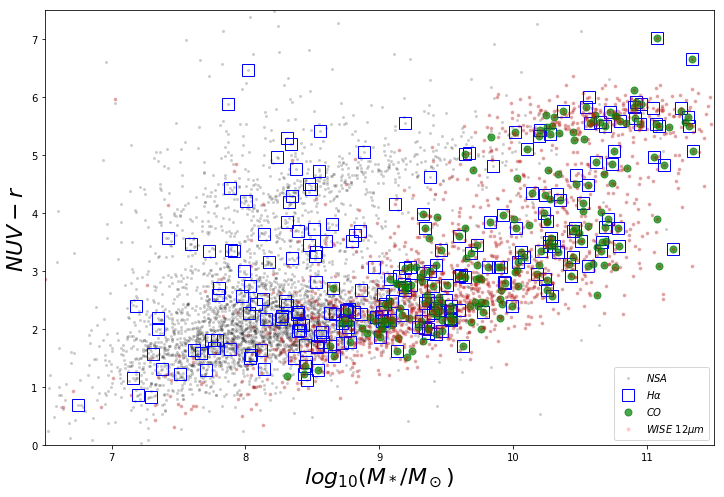

In [5]:
plt.figure(figsize=(12,8))
#plt.plot(jmass.MSTAR_50, NUVr,'k.',color='.3',alpha=.2,label='$NSA$')
plt.ylabel('$NUV - r$',fontsize=22)
plt.xlabel('$log_{10}(M_*/M_\odot)$',fontsize=22)
plt.plot(jmass.MSTAR_50,NUVr,'k.',mfc='k',mec='None',markersize=6,alpha=.2,label='$NSA$')
flag = ha_obs
plt.plot(jmass.MSTAR_50[flag],NUVr[flag],'ks',mfc='None',mec='b',markersize=12,label=r'$H\alpha$')
flag = COsample
plt.plot(jmass.MSTAR_50[flag],NUVr[flag],'ko',mfc='g',mec='g',markersize=7,label='$CO$',alpha=.7)
flag = wiseflag
plt.plot(jmass.MSTAR_50[flag],NUVr[flag],'ro',mfc='r',mec='None',markersize=4,alpha=.2,label='$WISE \ 12\mu m$')
plt.axis([6.5,11.5,0,7.5])
plt.legend()
plt.savefig('../plots/CO-sample-selection.png')

In [6]:
max(nsa.Z*3.e5)

3975.7566

The figure above shows all the NSA galaxies with recession velocity between 
$ 1000 < v_r 3975 $~km/s.  The gray points show all NSA galaxies, the green circles show objects that were targeted for CO observations, the red points show galaxies with a WISE 12$\mu$m SNR$>10$ and a detection at 22$\mu$m.





In [7]:
print('number in CO sample with Halpha observations = ',sum(ha_obs & ~COsample))
print('number in CO sample that need Halpha observations = ',sum(ha_obs & COsample))

number in CO sample with Halpha observations =  121
number in CO sample that need Halpha observations =  127


In [8]:
print('number with Halpha observations = ',sum(ha_obs))

number with Halpha observations =  248


In [9]:
def plotradec():
    plt.ylabel('$DEC \ (deg)$',fontsize=22)
    plt.xlabel('$RA \ (deg)$',fontsize=22)
    plt.plot(nsa.RA,nsa.DEC,'k.',mfc='k',mec='None',markersize=6,alpha=.2,label='$NSA$')
    flag = ha_obs
    plt.plot(nsa.RA[flag],nsa.DEC[flag],'ko',mfc='None',mec='b',markersize=12,label=r'$H\alpha$',alpha=.6)
    flag = COsample
    plt.plot(nsa.RA[flag],nsa.DEC[flag],'ko',mfc='g',mec='g',markersize=7,label='$CO$',alpha=.7)
    flag = wiseflag
    plt.plot(nsa.RA[flag],nsa.DEC[flag],'ro',mfc='r',mec='None',markersize=4,alpha=.5,label='$WISE \ 12\mu m$')
    plt.axis([115,280,-2,65])

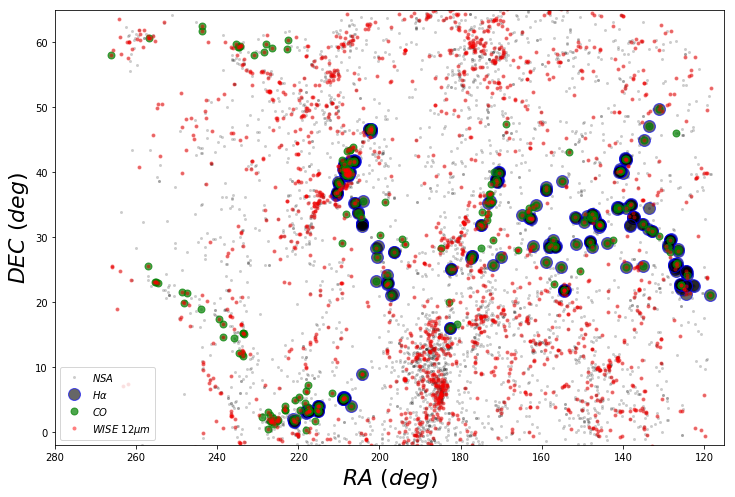

In [10]:
plt.figure(figsize=(12,8))
#plt.plot(jmass.MSTAR_50, NUVr,'k.',color='.3',alpha=.2,label='$NSA$')
plotradec()
plt.gca().invert_xaxis()
plt.legend()
plt.savefig('../plots/completeness-RA.png')

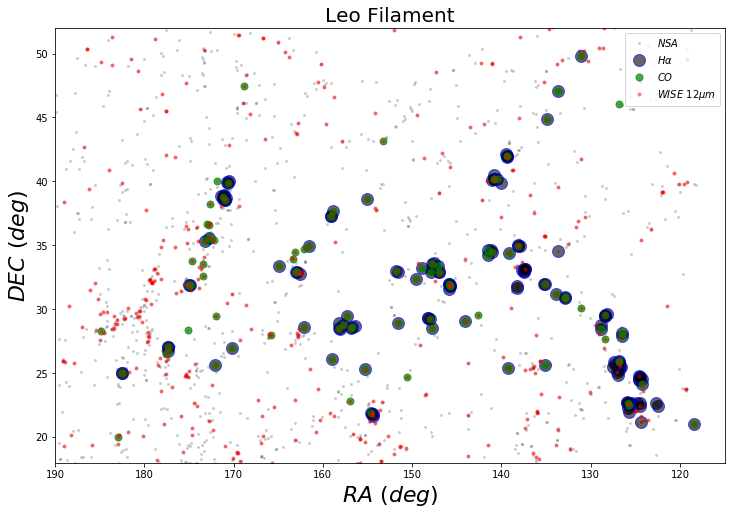

In [11]:
plt.figure(figsize=(12,8))
plotradec()
plt.axis([115,190,18,52])
plt.gca().invert_xaxis()
plt.legend()
plt.title('Leo Filament',fontsize=20)
plt.savefig('../plots/completeness-RA-Leo.png')

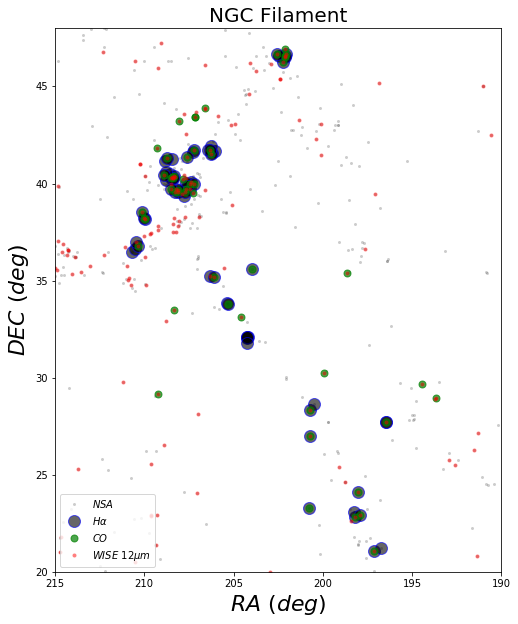

In [12]:
plt.figure(figsize=(8,10))
plotradec()
plt.axis([190,215,20,48])
plt.gca().invert_xaxis()
plt.legend(loc='lower left')
plt.title('NGC Filament',fontsize=20)
plt.savefig('../plots/completeness-RA-NGC.png')

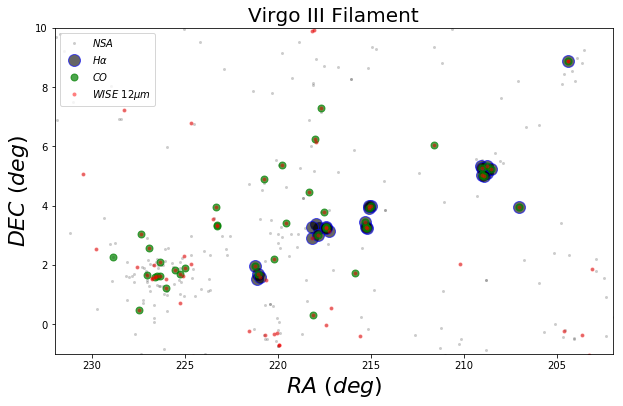

In [13]:
plt.figure(figsize=(10,6))
plotradec()
plt.axis([202,232,-1,10])
plt.gca().invert_xaxis()
plt.legend(loc='upper left')
plt.title('Virgo III Filament',fontsize=20)
plt.savefig('../plots/completeness-RA-Virgo3.png')

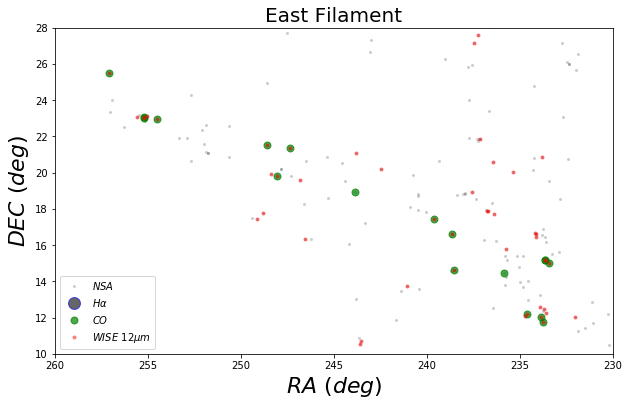

In [14]:
plt.figure(figsize=(10,6))
plotradec()
plt.axis([230,260,10,28])
plt.gca().invert_xaxis()
plt.legend(loc='lower left')
plt.title('East Filament',fontsize=20)
plt.savefig('../plots/completeness-RA-East.png')

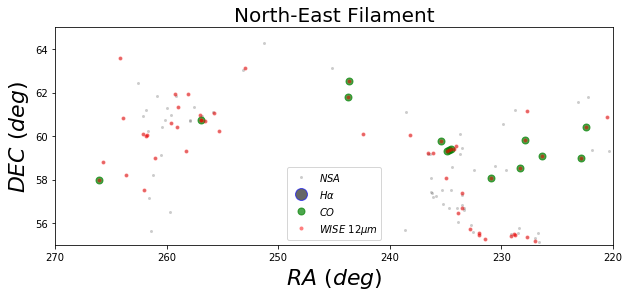

In [15]:
plt.figure(figsize=(10,4))
plotradec()
plt.axis([220,270,55,65])
plt.gca().invert_xaxis()
plt.legend(loc='lower center')
plt.title('North-East Filament',fontsize=20)
plt.savefig('../plots/completeness-RA-NE.png')